<a href="https://colab.research.google.com/github/MarsIana1804/Google_Colab_Notebooks/blob/main/Homework_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 4000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

print(len(x_train))


60000


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=784, out_features=128)  # Assuming input size is 784
    # Місце для вашого коду
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=128, out_features=256)
    # Місце для вашого коду
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=256, out_features=10)  # Assuming 10 classes for classification
    # Місце для вашого коду


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    #x = # Місце для вашого коду
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.output_layer(x, activation=1)  # Softmax activation for the output layer
    return x # Місце для вашого коду


In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворення прогнозів на мітки класів (argmax)
    y_pred_classes = tf.argmax(y_pred, axis=1, output_type=tf.int64)  # Explicitly set output_type to match y_true

    # Перетворення y_true до типу int64 для узгодження типів
    y_true = tf.cast(y_true, tf.int64)

    # Обчислення кількості правильних прогнозів
    correct_predictions = tf.equal(y_pred_classes, y_true)

    # Обчислення точності
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        trainable_variables = [var for var in neural_net.trainable_variables]

        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    # Повертаємо значення втрат для моніторингу
    return loss

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        # Отримуємо передбачення
        pred = neural_net(batch_x)

        # Обчислюємо точність і втрати
        current_accuracy = accuracy(pred, batch_y)
        current_loss = cross_entropy(pred, batch_y)

        # Додаємо поточну точність і втрати в історію
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())

        # Виводимо інформацію про навчання
        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")


Step 100, Loss: 304.0936, Accuracy: 0.6719
Step 200, Loss: 224.6059, Accuracy: 0.7734
Step 300, Loss: 162.8390, Accuracy: 0.8320
Step 400, Loss: 175.0285, Accuracy: 0.8086
Step 500, Loss: 157.5173, Accuracy: 0.8281
Step 600, Loss: 97.2780, Accuracy: 0.8438
Step 700, Loss: 97.0512, Accuracy: 0.8828
Step 800, Loss: 56.5955, Accuracy: 0.9297
Step 900, Loss: 98.6102, Accuracy: 0.8828
Step 1000, Loss: 99.2288, Accuracy: 0.8789
Step 1100, Loss: 97.1309, Accuracy: 0.8633
Step 1200, Loss: 73.7193, Accuracy: 0.9023
Step 1300, Loss: 116.5777, Accuracy: 0.8633
Step 1400, Loss: 94.3496, Accuracy: 0.8984
Step 1500, Loss: 68.6836, Accuracy: 0.9297
Step 1600, Loss: 87.7961, Accuracy: 0.8867
Step 1700, Loss: 75.5525, Accuracy: 0.9336
Step 1800, Loss: 105.1467, Accuracy: 0.8906
Step 1900, Loss: 83.1272, Accuracy: 0.8867
Step 2000, Loss: 55.5293, Accuracy: 0.9258
Step 2100, Loss: 71.5124, Accuracy: 0.9180
Step 2200, Loss: 70.6993, Accuracy: 0.9219
Step 2300, Loss: 105.2172, Accuracy: 0.8945
Step 2400, L

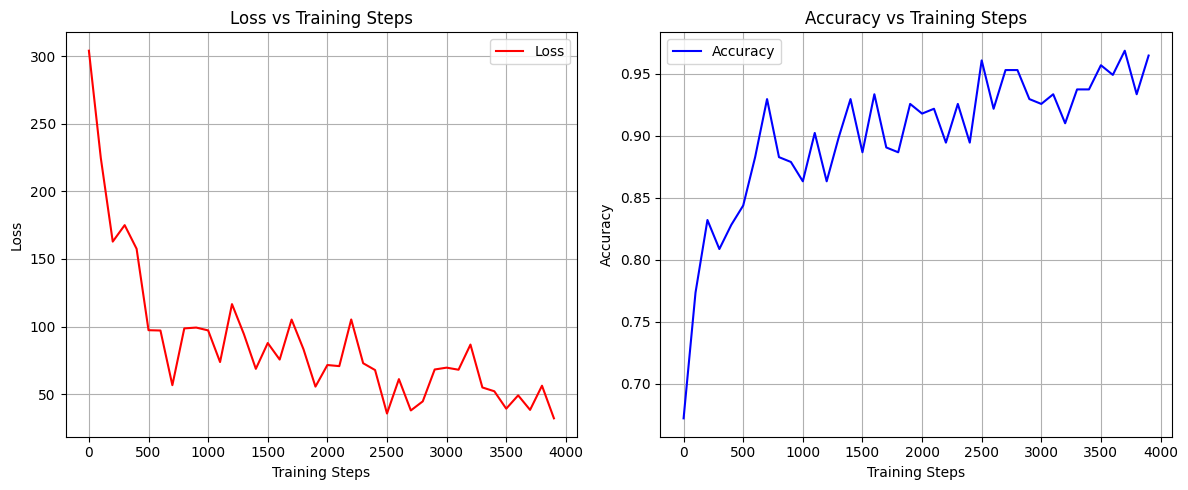

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись
# Виведіть графік функції втрат
# Місце для вашого коду

# Виведіть графік точності
# Місце для вашого коду

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(0, len(loss_history) * display_step, display_step), loss_history, label="Loss", color="red")
plt.title("Loss vs Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(0, len(accuracy_history) * display_step, display_step), accuracy_history, label="Accuracy", color="blue")
plt.title("Accuracy vs Training Steps")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
# Тестування моделі на тестових даних
# Місце для вашого коду

#Example-images-from-the-MNIST-dataset.png

# Prepare the test dataset
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(1)

# Обчисліть точність навченої нейромережі
def evaluate_model(neural_net, test_data):
    total_accuracy = 0
    num_batches = 0

    for batch_x, batch_y in test_data:
        # Передбачення для тестової партії
        pred = neural_net(batch_x)

        # Обчислення точності для партії
        batch_accuracy = accuracy(pred, batch_y)
        total_accuracy += batch_accuracy
        num_batches += 1

    # Середня точність на тестових даних
    return total_accuracy / num_batches

# Тестування моделі на тестових даних
test_accuracy = evaluate_model(neural_net, test_data)

# Виведення результату
print(f"Accuracy of the trained neural network on the test data: {test_accuracy:.4f}")


Accuracy of the trained neural network on the test data: 0.9178


In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду




Original Image shape: (280, 280)
Cropped Image shape: (28, 280)
height: 28, width: 280, num_digits: 10


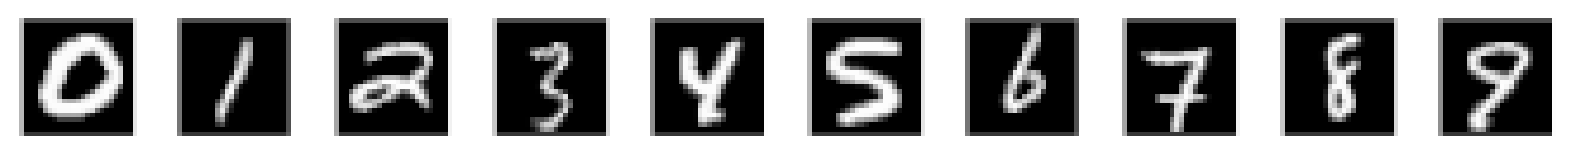

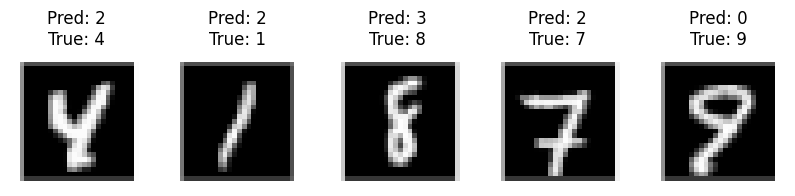

 Нейромережа помилилася у 5 випадках із 5.
 Точність на цій вибірці: 0.00%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


# Завантаження зображення
image_dir = os.getcwd()
relative_path = os.path.join(image_dir, "/content/drive/My Drive/Colab Notebooks/280_x_280_Mnist_Test.png")

image = Image.open(relative_path).convert("L")  # Градієнтне зображення
image = np.array(image)  # Перетворення в NumPy

print(f"Original Image shape: {image.shape}")  # Повинно бути (280, 280)

# Перевірка висоти зображення
if image.shape[0] not in [28, 280]:
    raise ValueError(f"Unexpected image height: {image.shape[0]}. Expected 28 or 280.")

# Обрізання верхньої частини, якщо зображення 280 пікселів
if image.shape[0] == 280:
    image = image[:28, :]

print(f"Cropped Image shape: {image.shape}")  # Повинно бути (28, 280)

# Розрізання на 28x28 зображення
height, width = image.shape
num_digits = width // 28  # Має бути 10

print(f'height: {height}, width: {width}, num_digits: {num_digits}')

digit_images = [image[:, i * 28 : (i + 1) * 28].astype("float32") / 255.0 for i in range(num_digits)]

# Відображення цифр
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap="gray")
    ax.axis("off")
plt.show()

# ТЕСТ НА 5 ВИПАДКОВИХ ЗОБРАЖЕННЯХ

# 1. Вибираємо 5 випадкових зображень
num_selected = 5
random_indices = np.random.choice(len(digit_images), num_selected, replace=False)
selected_images = np.array([digit_images[i] for i in random_indices]).reshape(num_selected, 28 * 28)

true_labels = [i for i in random_indices]

# 2. Передбачення нейромережі
predictions = neural_net(selected_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# 3. Візуалізація
plt.figure(figsize=(10, 5))
errors = 0  # Лічильник помилок

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_selected, i + 1)
    plt.imshow(digit_images[idx], cmap="gray")  # Відображаємо
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    plt.axis("off")

    if predicted_labels[i] != true_labels[i]:
        errors += 1

plt.show()

# 4. Виведення статистики
accuracy = ((num_selected - errors) / num_selected) * 100
print(f" Нейромережа помилилася у {errors} випадках із {num_selected}.")
print(f" Точність на цій вибірці: {accuracy:.2f}%")


Cropped Image shape: (28, 280)
height: 28, width: 280, num_digits: 10


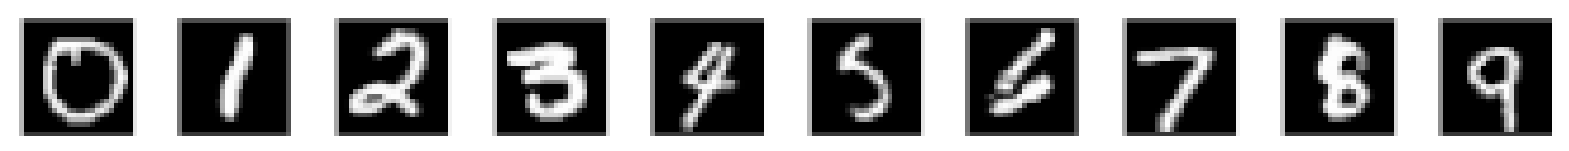

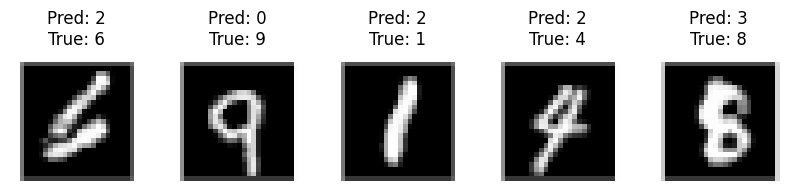

 Нейромережа помилилася у 5 випадках із 5.
 Точність на цій вибірці: 0.00%


In [ ]:
if image.shape[0] not in [28, 280]:
    raise ValueError(f"Unexpected image height: {image.shape[0]}. Expected 28 or 280.")

# Обрізання верхньої частини, якщо зображення 280 пікселів
if image.shape[0] == 280:
    image = image[252:280, :]

print(f"Cropped Image shape: {image.shape}")  # Повинно бути (28, 280)

# Розрізання на 28x28 зображення
height, width = image.shape
num_digits = width // 28  # Має бути 10

print(f'height: {height}, width: {width}, num_digits: {num_digits}')

digit_images = [image[:, i * 28 : (i + 1) * 28].astype("float32") / 255.0 for i in range(num_digits)]

# Відображення цифр
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap="gray")
    ax.axis("off")
plt.show()

# ТЕСТ НА 5 ВИПАДКОВИХ ЗОБРАЖЕННЯХ

# 1. Вибираємо 5 випадкових зображень
num_selected = 5
random_indices = np.random.choice(len(digit_images), num_selected, replace=False)
selected_images = np.array([digit_images[i] for i in random_indices]).reshape(num_selected, 28 * 28)

true_labels = [i for i in random_indices]

# 2. Передбачення нейромережі
predictions = neural_net(selected_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# 3. Візуалізація
plt.figure(figsize=(10, 5))
errors = 0  # Лічильник помилок

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_selected, i + 1)
    plt.imshow(digit_images[idx], cmap="gray")  # Відображаємо
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    plt.axis("off")

    if predicted_labels[i] != true_labels[i]:
        errors += 1

plt.show()

# 4. Виведення статистики
accuracy = ((num_selected - errors) / num_selected) * 100
print(f" Нейромережа помилилася у {errors} випадках із {num_selected}.")
print(f" Точність на цій вибірці: {accuracy:.2f}%")

Original Image shape: (280, 280)
Cropped Image shape: (28, 280)
height:28, width:280, num_digits:10


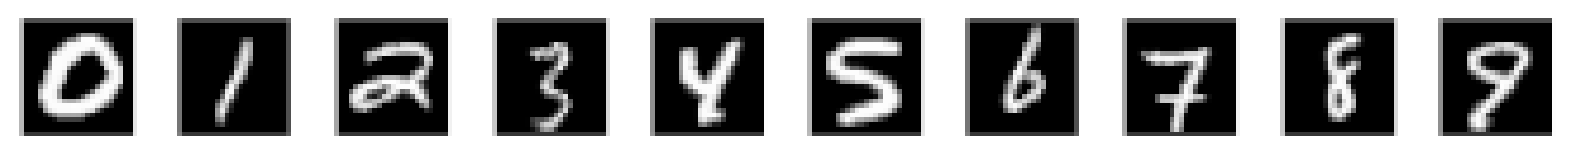

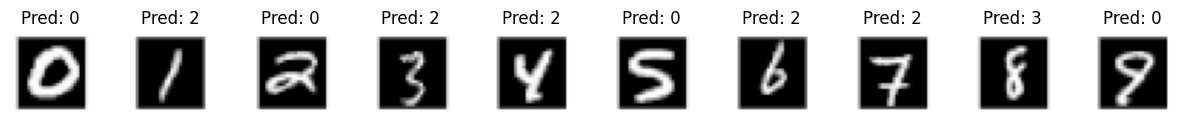

Original Image shape: (280, 280)
Cropped Image shape: (28, 280)
height:28, width:280, num_digits:10


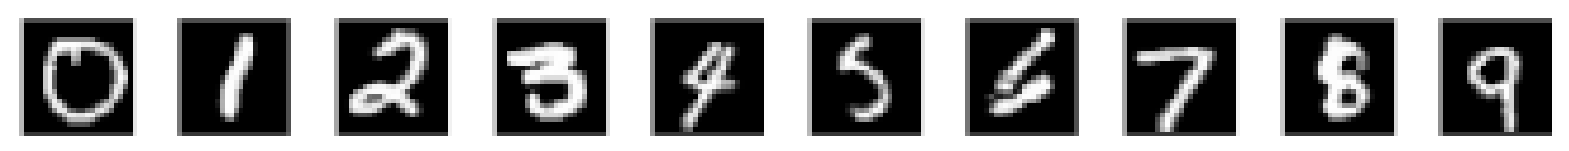

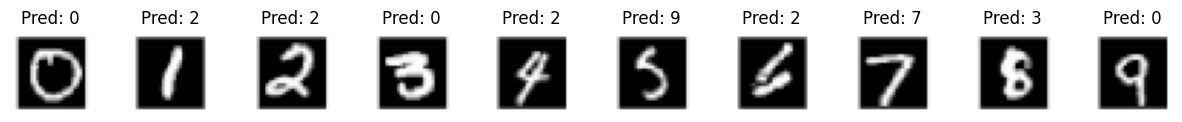

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


# Step 2: Load the image correctly
image_dir = os.getcwd()
relative_path = os.path.join(image_dir, "/content/drive/MyDrive/Colab Notebooks/280_x_280_Mnist_Test.png")

image = Image.open(relative_path).convert("L")  # Convert to grayscale
image = np.array(image)  # Convert to NumPy array

# Debugging: Print image shape
print(f"Original Image shape: {image.shape}")  # Should be (280, 280)

# Ensure image is the correct size
if image.shape[0] != 28 and image.shape[0] != 280:
    raise ValueError(f"Unexpected image height: {image.shape[0]}. Expected 28 or 280.")

# If image height is 280, crop the **top**
if image.shape[0] == 280:
    image = image[:28, :]  # Take only the top 28 rows of pixels

# Final debug print
print(f"Cropped Image shape: {image.shape}")  # Should now be (28, 280)

# Step 3: Extract individual 28x28 digit images
height, width = image.shape
num_digits = width // 28  # Should be 10

print(f'height:{height}, width:{width}, num_digits:{num_digits}')

digit_images = []
for i in range(num_digits):
    digit = image[:, i * 28 : (i + 1) * 28]  # Extract each 28x28 region
    digit = digit.astype("float32") / 255.0  # Normalize
    digit_images.append(digit)


# Extract and display digit images
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap="gray")
    ax.axis("off")

plt.show()





# Step 4: Make predictions using the trained neural network
predictions = []
for digit in digit_images:
    digit_flat = digit.reshape(1, 28 * 28)  # Flatten for the neural network
    pred = neural_net(digit_flat)
    predicted_label = tf.argmax(pred, axis=1).numpy()[0]
    predictions.append(predicted_label)

# Step 5: Display results properly
plt.figure(figsize=(15, 3))  # Correct aspect ratio for a single row
for i, (digit, pred) in enumerate(zip(digit_images, predictions)):
    plt.subplot(1, num_digits, i + 1)
    plt.imshow(digit, cmap="gray")
    plt.title(f"Pred: {pred}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5)  # Add spacing between digits
plt.show()













# Step 2: Load the image correctly
image_dir = os.getcwd()
relative_path = os.path.join(image_dir, "/content/drive/MyDrive/Colab Notebooks/280_x_280_Mnist_Test.png")

image = Image.open(relative_path).convert("L")  # Convert to grayscale
image = np.array(image)  # Convert to NumPy array

# Debugging: Print image shape
print(f"Original Image shape: {image.shape}")  # Should be (280, 280)

# Ensure image is the correct size
if image.shape[0] != 28 and image.shape[0] != 280:
    raise ValueError(f"Unexpected image height: {image.shape[0]}. Expected 28 or 280.")

# If image height is 280, crop the **top**
if image.shape[0] == 280:
    image = image[28:2*28, :]  # Take only the top 28 rows of pixels

# Final debug print
print(f"Cropped Image shape: {image.shape}")  # Should now be (28, 280)

# Step 3: Extract individual 28x28 digit images
height, width = image.shape
num_digits = width // 28  # Should be 10

print(f'height:{height}, width:{width}, num_digits:{num_digits}')

digit_images = []
for i in range(num_digits):
    digit = image[:, i * 28 : (i + 1) * 28]  # Extract each 28x28 region
    digit = digit.astype("float32") / 255.0  # Normalize
    digit_images.append(digit)


# Extract and display digit images
fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(digit_images[i], cmap="gray")
    ax.axis("off")

plt.show()





# Step 4: Make predictions using the trained neural network
predictions = []
for digit in digit_images:
    digit_flat = digit.reshape(1, 28 * 28)  # Flatten for the neural network
    pred = neural_net(digit_flat)
    predicted_label = tf.argmax(pred, axis=1).numpy()[0]
    predictions.append(predicted_label)

# Step 5: Display results properly
plt.figure(figsize=(15, 3))  # Correct aspect ratio for a single row
for i, (digit, pred) in enumerate(zip(digit_images, predictions)):
    plt.subplot(1, num_digits, i + 1)
    plt.imshow(digit, cmap="gray")
    plt.title(f"Pred: {pred}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5)  # Add spacing between digits
plt.show()
